In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/sample_submission.csv
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train.zip
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv


In [5]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
from tqdm import tqdm 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_selection import RFE

In [6]:
PATH = '/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2'
SEED = 89

In [7]:
def predict_and_submit(estimator, X_train, y_train, X_test, filename):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict_proba(X_test)[:, 1]
    submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'), 
                             index_col='session_id')
    submission['target'] = y_pred
    submission.to_csv(filename)

In [8]:
# create lists of similar feature names
sites = ['site{}'.format(i) for i in range(1, 11)]
times = ['time{}'.format(i) for i in range(1, 11)]

train_data = pd.read_csv(os.path.join(PATH, 'train_sessions.csv'),
                         index_col='session_id', parse_dates=times)
test_data = pd.read_csv(os.path.join(PATH, 'test_sessions.csv'),
                        index_col='session_id', parse_dates=times)
train_data[sites] = train_data[sites].fillna(0).astype('int')
test_data[sites] = test_data[sites].fillna(0).astype('int')

# load and invert the site dictionary
with open(os.path.join(PATH, 'site_dic.pkl'), 'rb') as file:
    sites_encoder = pickle.load(file)
sites_encoder['missing_value'] = 0
sites_decoder = {site_id:site for (site, site_id) in sites_encoder.items()}

train_data.head(3)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0


In [9]:
train_data['target'].value_counts(normalize=True)  # imbalanced classes

0    0.990941
1    0.009059
Name: target, dtype: float64

In [10]:
# Time range of training data
train_data['time1'].min(), train_data['time1'].max()

(Timestamp('2013-01-12 08:05:57'), Timestamp('2014-04-30 23:39:53'))

In [11]:
# Time range of test data
test_data['time1'].min(), test_data['time1'].max()

(Timestamp('2014-05-01 17:14:03'), Timestamp('2014-12-05 23:26:53'))

This means that we will only predict the target feature for future sessions based on past sessions. 
So let's sort training instances by start time and use TimeSeriesSplit as a cross-validator

In [12]:
train_data = train_data.sort_values(by='time1')
y_train = train_data['target']
alice_idx = train_data[train_data['target'] == 1].index
others_idx = train_data[train_data['target'] == 0].index

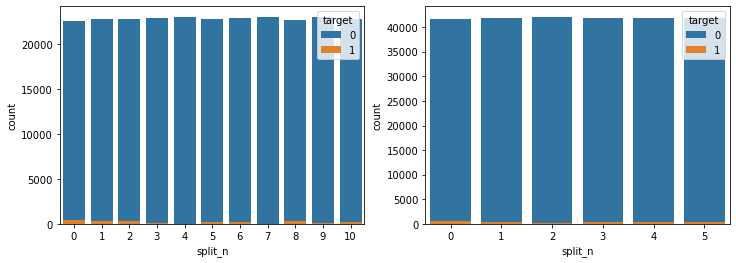

In [13]:
# check proportion of classes in each split of the cross-validator
# for 10 and 5 splits:

_, axes = plt.subplots(1, 2, figsize=(12, 4))
for (ax, n) in enumerate([10, 5]):
    tscv = TimeSeriesSplit(n_splits=n)
    idx_cv_split = [i for i in tscv.split(train_data)]
    train_data['split_n'] = 0
    for i, (train_idx, valid_idx) in enumerate(idx_cv_split, 1):
        train_data['split_n'].iloc[valid_idx] = i
    sns.countplot('split_n', hue='target', data=train_data, 
                  dodge=False, ax=axes[ax]);

The proportions of classes in each split are more uniform with 5 splits than with 10, so let's use 5 split in cross-validation

In [14]:
def get_cv_scores(X, y, C=1, n_splits=5):
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    logit = LogisticRegression(C=C, solver='liblinear', random_state=SEED)
    cv_scores = cross_val_score(logit, X, y, scoring='roc_auc', n_jobs=-1,
                                cv=tscv)
    return cv_scores

## Sites features

Use "bag of words" method taking one site as one word and sessions as sentences of words

### CountVectorizer

In [ ]:
# transform sessions rows to strings containing site IDs separated by space
train_sessions_ids = train_data[sites].apply(
    lambda row: ' '.join([str(i) for i in row if i != 0]), 
    axis=1).to_list()
test_sessions_ids = test_data[sites].apply(
    lambda row: ' '.join([str(i) for i in row if i != 0]), 
    axis=1).to_list()

In [ ]:
# choose the best parameters for CountVectorizer

ngram_range = [1, 2, 3, 4, 5]
max_feat_range = [50000, 70000, 80000, 90000, 100000, 110000]

# create a DataFrame that will contain average score of cross-validation 
# with different parameters of the vectorizer
count_vectorizer_grid = pd.DataFrame(
    index=['(1, {})'.format(i) for i in ngram_range],
    columns=max_feat_range)

for i in tqdm(ngram_range):
    index = '(1, {})'.format(i)
    
    for col in max_feat_range:
        count_vect = CountVectorizer(ngram_range=(1, i), max_features=col)
        X_train_count = count_vect.fit_transform(train_sessions_ids)
        scores = get_cv_scores(X_train_count, y_train)
        
        count_vectorizer_grid.loc[index, col] = scores.mean()

In [ ]:
# visualize CountVectorizer scores depending on ngram_range and max_features parameters
sns.heatmap(count_vectorizer_grid.astype('float'),
            cmap='YlGnBu', annot=True, fmt='.5g');
plt.savefig('CountVectorizer_scores_splits5.png', dpi=400)

In [ ]:
# fit a logistic regression model using CountVectorizer with the best parameters
count_vect = TfidfVectorizer(ngram_range=(1, 2), max_features=90000)
X_train_count = count_vect.fit_transform(train_sessions_ids)
X_test_count = count_vect.transform(test_sessions_ids)

logit = LogisticRegression(C=1, solver='liblinear', random_state=SEED)
predict_and_submit(logit, X_train=X_train_count, y_train=y_train,
                   X_test=X_test_count, filename='submission1.csv')

# public score = 0.91763 (cross-validation score = 0.83665)

### TfidfVectorizer

In [15]:
# transform sessions rows to strings containing site names separated by space
train_sessions_sites = train_data[sites].apply(
    lambda row: ' '.join([sites_decoder[i] for i in row if i != 0]),
    axis=1).to_list()
test_sessions_sites = test_data[sites].apply(
    lambda row: ' '.join([sites_decoder[i] for i in row if i != 0]), 
    axis=1).to_list()

In [ ]:
# choose the best parameters for TfidfVectorizer

ngram_range = [2, 3, 4, 5, 6]
max_feat_range = [30000, 40000, 50000, 60000, 80000]

# create a DataFrame that will contain average score of cross-validation 
# with different parameters of the vectorizer
tfidf_vectorizer_grid = pd.DataFrame(
    index=['(1, {})'.format(i) for i in ngram_range],
    columns=max_feat_range)

for i in tqdm(ngram_range):
    index = '(1, {})'.format(i)
    
    for col in max_feat_range:
        vectorizer_params={'ngram_range': (1, i), 
                           'max_features': col,
                           'tokenizer': lambda s: s.split()}
        tfidf_vect = TfidfVectorizer(**vectorizer_params)
        X_train_tfidf = tfidf_vect.fit_transform(train_sessions_sites)
        scores = get_cv_scores(X_train_tfidf, y_train)
        
        tfidf_vectorizer_grid.loc[index, col] = scores.mean()

In [ ]:
# visualize TfidfVectorizer scores depending on ngram_range and max_features parameters
sns.heatmap(tfidf_vectorizer_grid.astype('float'),
            cmap='YlGnBu', annot=True, fmt='.5g');
plt.savefig('TfidfVectorizer_scores_splits5.png', dpi=400)

In [16]:
# fit a logistic regression model using TfidfVectorizer with the best parameters
vectorizer_params={'ngram_range': (1, 4), 
                   'max_features': 30000,
                   'tokenizer': lambda s: s.split()}
tfidf_vect = TfidfVectorizer(**vectorizer_params)
X_train_tfidf = tfidf_vect.fit_transform(train_sessions_sites)
X_test_tfidf = tfidf_vect.transform(test_sessions_sites)

logit = LogisticRegression(C=1, solver='liblinear', random_state=SEED)
predict_and_submit(logit, X_train=X_train_tfidf, y_train=y_train,
                   X_test=X_test_tfidf, filename='submission2.csv')

# public score = 0.92149 (cross-validation score = 0.84201)

Site features were extracted in two ways: using CountVectorizer and TfidfVectorizer models.
Average cross-validation score with CountVectorizer is 0.837; with TfidfVectorizer this number is 0.842.
Public score on test data are 0.91763 and 0.92149 for CountVectorizer and TfidfVectorizer correspondingly.
Therefore, we prefer TfidfVectorizer with the best score on cross-validation and test data.

### Other site features

In [17]:
def concatenate_features(X_sparse, X_added, scaler=None, to_scale=[]):
    
    X_added_unscaled = X_added[set(X_added.columns) - set(to_scale)]
    X = csr_matrix(hstack([X_sparse, X_added_unscaled]))
    
    if to_scale:
        if scaler is None:
            scaler = StandardScaler()
            scaler.fit(X_added[to_scale])
        X_added_scaled = scaler.transform(X_added[to_scale])
        X = csr_matrix(hstack([X, X_added_scaled]))
    
    return X, scaler

In [18]:
train_sites = train_data[sites]
test_sites = test_data[sites]
for site in sites:
    train_sites[site] = train_sites[site].apply(lambda x: sites_decoder[x])
    test_sites[site] = test_sites[site].apply(lambda x: sites_decoder[x])

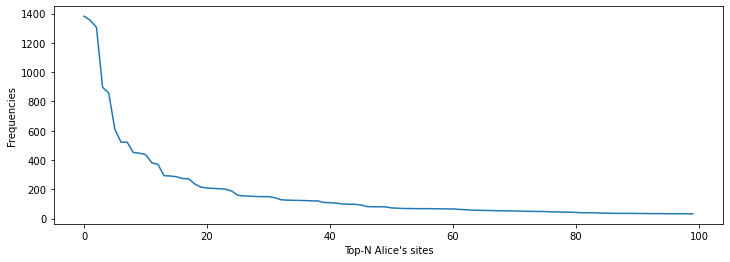

In [19]:
# calculate frequency for each site in Alice's sessions
alice_freq = pd.Series(train_sites.loc[alice_idx].values.flatten()
                      ).value_counts()
alice_freq_dict = {}
for site in alice_freq.index:
    alice_freq_dict[site] = alice_freq[site]

_, axes = plt.subplots(figsize=(12, 4))
axes.plot(list(alice_freq_dict.values())[:100])
axes.set_xlabel("Top-N Alice's sites")
axes.set_ylabel('Frequencies');

In [20]:
# feature that contains 1 if frequency of at least one site in session
# corresponds the condition (otherwise 0)

def create_freq_feature(X, feature_name, condition, freq_dict):
    
    condition = 'freq ' + condition    # e.g. 'freq > 100'
    X[feature_name] = X[sites].apply(
        lambda row: [freq_dict.get(site, 0) for site in list(row)], 
        axis=1)
    X[feature_name] = X[feature_name].apply(
        lambda row: max([(1 if eval(condition) else 0 ) for freq in row]))

In [21]:
create_freq_feature(train_sites, 'alice_top', '> 900', alice_freq_dict)
create_freq_feature(train_sites, 'alice_antitop', '== 1', alice_freq_dict)

In [22]:
train_sites['sites'] = train_sites[sites].apply(
    lambda row: [site for site in list(row) if site != 'missing_value'], 
    axis=1)
train_sites['n_sites'] = train_sites['sites'].apply(
    lambda x: len(x))
train_sites['n_uniq_sites'] = train_sites['sites'].apply(
    lambda x: pd.Series(x).nunique())
train_sites['percent_uniq_sites'] = (
    train_sites['n_uniq_sites'] / train_sites['n_sites'])

In [23]:
domains = pd.Series(train_sites[sites].values.flatten()).apply(
    lambda x: x.split('.')[-1])
domains.value_counts().head(10)

com              1499368
fr                411545
org               165500
net               155393
missing_value     122730
gov                86769
cn                 15340
uk                 11621
ru                  5878
io                  5567
dtype: int64

In [24]:
# use one-hot encoding for more frequent domains
for domain in ['com', 'fr', 'org', 'net', 'gov', 'cn']:
    train_sites[domain] = train_sites['sites'].apply(
        lambda x: sum([1 for i in x if i.endswith(domain)]))

In [25]:
feats = ['alice_top', 'alice_antitop', 'percent_uniq_sites',
         'com', 'fr', 'org', 'net', 'gov', 'cn']
X_train_sites, _ = concatenate_features(X_train_tfidf, 
                                        train_sites[feats], 
                                        to_scale=feats)
scores = get_cv_scores(X_train_sites, y_train, C=1)
scores.mean()   

0.8459569130735278

New features improve score so let's create this features on test data

In [26]:
# new features improve score so create this features on test data
create_freq_feature(test_sites, 'alice_top', '> 900', alice_freq_dict)
create_freq_feature(test_sites, 'alice_antitop', '== 1', alice_freq_dict)

test_sites['sites'] = test_sites[sites].apply(
    lambda row: [site for site in list(row) if site != 'missing_value'], 
    axis=1)
test_sites['n_sites'] = test_sites['sites'].apply(
    lambda x: len(x))
test_sites['n_uniq_sites'] = test_sites['sites'].apply(
    lambda x: pd.Series(x).nunique())
test_sites['percent_uniq_sites'] = (
    test_sites['n_uniq_sites'] / test_sites['n_sites'])

for domain in ['com', 'fr', 'org', 'net', 'gov', 'cn']:
    test_sites[domain] = test_sites['sites'].apply(
        lambda x: sum([1 for i in x if i.endswith(domain)]))
test_sites.columns

Index(['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8',
       'site9', 'site10', 'alice_top', 'alice_antitop', 'sites', 'n_sites',
       'n_uniq_sites', 'percent_uniq_sites', 'com', 'fr', 'org', 'net', 'gov',
       'cn'],
      dtype='object')

In [27]:
feats = ['alice_top', 'alice_antitop', 'percent_uniq_sites',
         'com', 'fr', 'org', 'net', 'gov', 'cn']
X_train_sites, scaler = concatenate_features(X_train_tfidf, 
                                             train_sites[feats], 
                                             to_scale=feats)
X_test_sites, scaler = concatenate_features(X_test_tfidf, 
                                            test_sites[feats], 
                                            scaler=scaler, 
                                            to_scale=feats)
logit = LogisticRegression(C=1, solver='liblinear', 
                           random_state=SEED)
predict_and_submit(logit, X_train_sites, y_train, 
                   X_test_sites, 'submission3.csv')

# public score = 0.92149 (cv_score = 0.84201) without new features
# public score = 0.92642 (cv_score = 0.84596) with new features

The public score improved from 0.92149 to 92642 by adding new site features.

## Creating time features

In [48]:
X_train_times = train_data[times]

X_train_times['yyyymm'] = X_train_times['time1'].apply(
    lambda x: 12 * (x.year - 2013) + x.month)
X_train_times['weekday'] = X_train_times['time1'].apply(
    lambda x: x.dayofweek)
X_train_times['hour'] = X_train_times['time1'].apply(
    lambda x: x.hour)

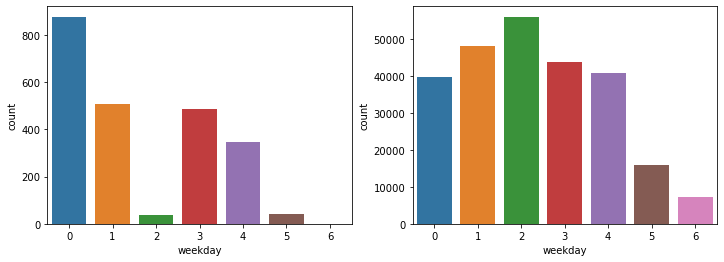

In [49]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot('weekday', data=X_train_times.loc[alice_idx], 
              ax=axes[0])
sns.countplot('weekday', data=X_train_times.loc[others_idx], 
              ax=axes[1]);

In [50]:
X_train_times['online_day'] = X_train_times['weekday'].apply(
    lambda x: 1 if (x in {0, 1, 3, 4}) else 0)

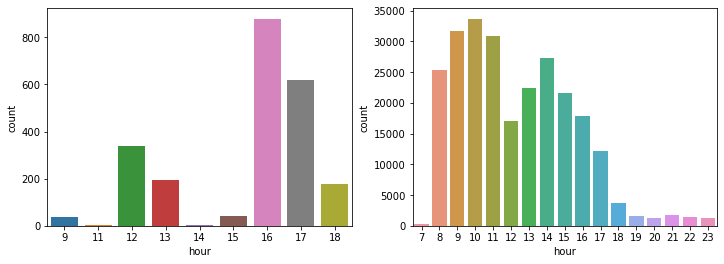

In [51]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot('hour', data=X_train_times.loc[alice_idx], 
              ax=axes[0])
sns.countplot('hour', data=X_train_times.loc[others_idx], 
              ax=axes[1]);

***Let's convert the session start time to trigonometric functions. 
Let 24 hours correspond to 360 degrees. 
Then 1 hour contains 15 degrees. 
Then N hours is equal to $\frac{15 \cdot N \cdot 2\pi}{360}$ radians***

In [52]:
# convert the session start time to sin and cos functions

def to_radians(hour, minute, second):
    degrees = 15 * (hour + minute / 60 + second / 3600)
    radians = 2 * np.pi * degrees / 360
    return radians

X_train_times['hour_sin'] = X_train_times['time1'].apply(
    lambda x: np.sin(to_radians(x.hour, x.minute, x.second)))
X_train_times['hour_cos'] = X_train_times['time1'].apply(
    lambda x: np.cos(to_radians(x.hour, x.minute, x.second)))

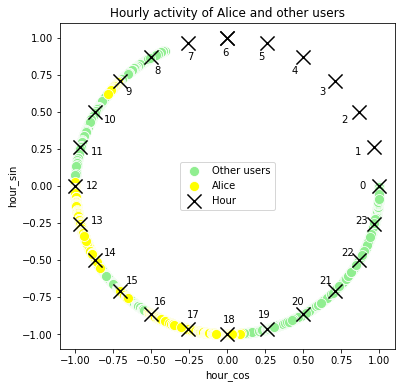

In [53]:
plt.figure(figsize=(6, 6))
sns.scatterplot('hour_cos', 'hour_sin', color='lightgreen', 
                s=100, label='Other users', 
                data=X_train_times.loc[others_idx])
sns.scatterplot('hour_cos', 'hour_sin', color='yellow', 
                s=100, label='Alice', 
                data=X_train_times.loc[alice_idx])

for hour in range(0, 24):
    cos = np.cos(to_radians(hour, 0, 0))
    sin = np.sin(to_radians(hour, 0, 0))
    plt.scatter(cos, sin, color='black', marker = 'x', 
                linewidth=1.5,  s=200)
    plt.annotate(str(hour), xy=(cos, sin), 
                 xytext=(cos*0.9 - 0.03, sin*0.9 - 0.02))
    

plt.scatter(0, 1, color='black', marker = 'x', s=200, 
            linewidth=1.5, label='Hour')
plt.legend()
plt.title('Hourly activity of Alice and other users');

In [54]:
X_train_times['morning'] = X_train_times['hour'].apply(
    lambda x: 1 if x in {7, 8, 9, 10, 11} else 0)
X_train_times['day'] = X_train_times['hour'].apply(
    lambda x: 1 if x in {12, 13, 14, 15, 16, 17, 18} else 0)
X_train_times['evening'] = X_train_times['hour'].apply(
    lambda x: 1 if x in {19, 20, 21, 22, 23} else 0)
X_train_times['night'] = X_train_times['hour'].apply(
    lambda x: 1 if x in {0, 1, 2, 3, 4, 5, 6} else 0)

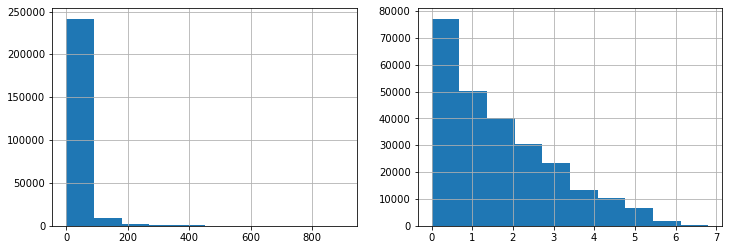

In [55]:
X_train_times['duration'] = (X_train_times[times].max(axis=1) 
                             - X_train_times['time1']).apply(
                             lambda td: td.seconds)
X_train_times['time_per_site'] = (
    X_train_times['duration'] / train_sites['n_sites']) 
X_train_times['log_time_per_site'] = np.log(
    X_train_times['time_per_site'] + 1) 

_, axes = plt.subplots(1, 2, figsize=(12, 4))
X_train_times['time_per_site'].hist(ax=axes[0]);
X_train_times['log_time_per_site'].hist(ax=axes[1]);

In [56]:
X_train_times.drop(times, axis=1, inplace=True)
X_train_times.columns

Index(['yyyymm', 'weekday', 'hour', 'online_day', 'hour_sin', 'hour_cos',
       'morning', 'day', 'evening', 'night', 'duration', 'time_per_site',
       'log_time_per_site'],
      dtype='object')

## Feature selection

In [60]:
def forward_feature_selection(X_sparse, X_added, y, n_add=None, C=1):
    
    # DataFrame for writing results of selection
    selection = pd.DataFrame(columns=['added', 'mean_cv_score',
                                      'n_features', 'features'])
    X = X_sparse.copy()
    X_added = X_added.copy()
    
    # number of best features to add
    n_add = X_added.shape[1] if (n_add is None) else n_add
    
    # create scaled features
    for feat in X_added.columns:
        X_added[feat + '_scaled'] = StandardScaler().fit_transform(
                         X_added[feat].values.reshape(-1, 1))
    
    features = []
    for i in tqdm(range(n_add)):
        
        # finding the best feature to add in the current iteration
        cv_mean_results = {}
        for feat in X_added.columns:
            X_tmp, _ = concatenate_features(X, X_added[[feat]])
            cv_scores = get_cv_scores(X_tmp, y, C=C)
            cv_mean_results[cv_scores.mean()] = feat
            
        best_score = max(cv_mean_results)
        best_feature = cv_mean_results[best_score]
        features.append(best_feature)
        X, _ = concatenate_features(X, X_added[[best_feature]])
        
        selection.loc[i, 'added'] = best_feature
        selection.loc[i, 'mean_cv_score'] = best_score
        selection.loc[i, 'n_features'] = i + 1
        selection.loc[i, 'features'] = list(features)
        
        # exclude the best feature from further selection
        X_added.drop(best_feature, axis=1, inplace=True)
        if best_feature.endswith('_scaled'):
            X_added.drop(best_feature[:-7], axis=1, inplace=True)
        else:
            X_added.drop(best_feature + '_scaled', axis=1, inplace=True)
        
    return selection

In [61]:
feats = ['online_day', 'hour_sin', 'hour_cos', 'log_time_per_site',
         'yyyymm', 'morning', 'day', 'evening', 'night']
selection = forward_feature_selection(X_train_sites, X_train_times[feats], 
                                      y_train)
selection

100%|██████████| 9/9 [13:29<00:00, 90.00s/it] 


,added,mean_cv_score,n_features,features
0,day_scaled,0.916556,1,[day_scaled]
1,online_day,0.929607,2,"[day_scaled, online_day]"
2,log_time_per_site,0.931528,3,"[day_scaled, online_day, log_time_per_site]"
3,yyyymm_scaled,0.931761,4,"[day_scaled, online_day, log_time_per_site, yy..."
4,evening_scaled,0.93199,5,"[day_scaled, online_day, log_time_per_site, yy..."
5,morning_scaled,0.932001,6,"[day_scaled, online_day, log_time_per_site, yy..."
6,night_scaled,0.932003,7,"[day_scaled, online_day, log_time_per_site, yy..."
7,hour_cos_scaled,0.923695,8,"[day_scaled, online_day, log_time_per_site, yy..."
8,hour_sin,0.92357,9,"[day_scaled, online_day, log_time_per_site, yy..."


In [69]:
best_features = ['morning', 'day', 'evening', 'night', 
                 'yyyymm', 'log_time_per_site', 'online_day']
to_scale = ['morning', 'day', 'evening', 'night', 'yyyymm']

In [65]:
# create new time features on test data
X_test_times = test_data[times]
X_test_times['yyyymm'] = X_test_times['time1'].apply(
    lambda x: 12 * (x.year - 2013) + x.month)
X_test_times['weekday'] = X_test_times['time1'].apply(
    lambda x: x.dayofweek)
X_test_times['online_day'] = X_test_times['weekday'].apply(
    lambda x: 1 if (x in {0, 1, 3, 4}) else 0)

X_test_times['hour'] = X_test_times['time1'].apply(
    lambda x: x.hour)
X_test_times['morning'] = X_test_times['hour'].apply(
    lambda x: 1 if x in {7, 8, 9, 10, 11} else 0)
X_test_times['day'] = X_test_times['hour'].apply(
    lambda x: 1 if x in {12, 13, 14, 15, 16, 17, 18} else 0)
X_test_times['evening'] = X_test_times['hour'].apply(
    lambda x: 1 if x in {19, 20, 21, 22, 23} else 0)
X_test_times['night'] = X_test_times['hour'].apply(
    lambda x: 1 if x in {0, 1, 2, 3, 4, 5, 6} else 0)

X_test_times['duration'] = (X_test_times[times].max(axis=1) 
                             - X_test_times['time1']).apply(
                             lambda td: td.seconds)
X_test_times['time_per_site'] = (
    X_test_times['duration'] / test_sites['n_sites'])
X_test_times['log_time_per_site'] = np.log(
    X_test_times['time_per_site'] + 1)
X_test_times.drop(times, axis=1, inplace=True)

In [70]:
# concatenate time features and site features to total DataFrames
X_train, scaler = concatenate_features(X_train_sites, 
                                       X_train_times[best_features], 
                                       to_scale=to_scale)
X_test, scaler = concatenate_features(X_test_sites, 
                                      X_test_times[best_features], 
                                      scaler=scaler, to_scale=to_scale)

In [74]:
# find the best hyperparameters
logit = LogisticRegression(solver='liblinear', random_state=SEED)
params = {'C': np.logspace(-1, 2, 40)}
grid = GridSearchCV(logit, param_grid=params, scoring='roc_auc', 
                    cv=TimeSeriesSplit(5), verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

grid.best_score_, grid.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.2min finished


(0.9321067195762168, {'C': 1.1937766417144369})

In [75]:
# set the best hyperparameter C and get the final predictions
logit = LogisticRegression(C=1.194, solver='liblinear', random_state=SEED)
predict_and_submit(logit, X_train, y_train, X_test, 'submission4.csv')

### The final public score is 0.95709 (this is the top 9%)